# Examples of manipulating data

In [1]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
import xarray as xr
from xnemogcm import open_domain_cfg, get_metrics
import xgcm
import cartopy.crs as ccrs
import cmocean

# Add SouthernDemons library to PATH
sys.path.append(os.path.abspath("../lib/"))
from teos_ten import teos_sigma0

/home/users/afstyles/.conda/envs/ecco-notebook3/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(


# Code parameters

In [2]:
# Subdomain information (As inputted into TRACMASS, note non-pythonic indexing)
imindom = 1
imaxdom = 1440
jmindom = 1
jmaxdom = 400
kmindom = 1
kmaxdom = 75

# Location of the TRACMASS run
data_dir = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_bwd/")

# Location of the OUTPUT directory created when running SouthernDemons executable
out_dir = os.path.abspath(data_dir + "/OUTPUT.ORCA025_newindex/")

# Location of masks and grid information for the model
grid_path = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/DRAKKAR_SET/topo/" )
grid_files = ['mask.nc','mesh_hgr.nc','mesh_zgr.nc']

# Location of neutral density surfaces
ndense_path = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/SouthernDemons/neutraldensity/output/ORCA025_Dec_70_398_extend/*.nc" )

cal_months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Load the model grid information

In [3]:
ds_domain = open_domain_cfg( datadir=grid_path, files = grid_files )
# xgcm_grid = xgcm.Grid(ds_domain, metrics=get_metrics(ds_domain), periodic=True)

In [4]:
ds_domain

<xarray.Dataset> Size: 6GB
Dimensions:       (z_c: 75, y_c: 1021, x_c: 1442, x_f: 1442, y_f: 1021, z_f: 75)
Coordinates: (12/18)
    glamt         (y_c, x_c) float32 6MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    glamu         (y_c, x_f) float32 6MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    glamv         (y_f, x_c) float32 6MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    glamf         (y_f, x_f) float32 6MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    gphit         (y_c, x_c) float32 6MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    gphiu         (y_c, x_f) float32 6MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    ...            ...
  * x_f           (x_f) float64 12kB 0.5 1.5 2.5 ... 1.44e+03 1.44e+03 1.442e+03
  * y_f           (y_f) float64 8kB 0.5 1.5 2.5 ... 1.018e+03 1.02e+03 1.02e+03
  * z_f           (z_f) float64 600B -0.5 0.5 1.5 2.5 ... 70.5 71.5 72.5 73.5
  * x_c           (x_c) int64 12kB 0 1 2 3 4 5 ... 1436 1437 1438 1439 1440 1441
  * y_c           (y_c) int64 8kB 0 1 2 3 4 5 ... 1015 1016 1017 1018 1019 1020
  * z_c           (z_c) int64 600B 0 1 2 3 4 5 6 7 8 ... 67 68 69 70 71 72 73 74
Data variables: (12/29)
    time_counter  float64 8B dask.array<chunksize=(), meta=np.ndarray>
    tmask         (z_c, y_c, x_c) int8 110MB dask.array<chunksize=(5, 128, 91), meta=np.ndarray>
    umask         (z_c, y_c, x_f) int8 110MB dask.array<chunksize=(5, 128, 91), meta=np.ndarray>
    vmask         (z_c, y_f, x_c) int8 110MB dask.array<chunksize=(5, 128, 91), meta=np.ndarray>
    fmask         (z_c, y_f, x_f) int8 110MB dask.array<chunksize=(5, 128, 91), meta=np.ndarray>
    tmaskutil     (y_c, x_c) int8 1MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    ...            ...
    e3v_0         (z_c, y_f, x_c) float64 883MB dask.array<chunksize=(5, 128, 91), meta=np.ndarray>
    e3w_0         (z_f, y_c, x_c) float64 883MB dask.array<chunksize=(5, 128, 91), meta=np.ndarray>
    gdepu         (z_c, y_c, x_f) float32 442MB dask.array<chunksize=(5, 128, 91), meta=np.ndarray>
    gdepv         (z_c, y_f, x_c) float32 442MB dask.array<chunksize=(5, 128, 91), meta=np.ndarray>
    e3t_1d        (z_c) float64 600B dask.array<chunksize=(16,), meta=np.ndarray>
    e3w_1d        (z_f) float64 600B dask.array<chunksize=(16,), meta=np.ndarray>
Attributes:
    DOMAIN_size_global:  [1442 1021]

# Load some trajectory data

The TRACMASS runs output two important files
* `df_ini`: Seeding information for all trajectories (Starting position and properties for forward-in-time experiments)
* `df_out`: Trajectories that terminated within the experiment time window ( contact with mixed layer base or exiting domain )
* `df_vent`: Subset of `df_out`. Trajectories that made contact with the mixed layer base in the experiment time window

In [5]:
# Use dask to load the tabulated data lazily 
df_ini = dd.read_parquet(out_dir + f"/df_ini.combined.parquet")
df_out = dd.read_parquet(out_dir + f"/df_out.combined.parquet")
df_vent = dd.read_parquet(out_dir + f"/df_vent.parquet")

For `df_ini` and `df_out` the data contains the respective fields
* `ntrajc`: Trajectory number, essentially a label to keep track of trajectories between tables. Note that `ntraj` is not the correct label!
* `x`, `y`, `z`: Horizontal and vertical coordinates in grid coordinates. E.g. x = 8 means the center of the 8th grid cell in the x direction
* `subvol`: Volume of the fluid parcel, used to weight statistics
* `time`: Time in seconds (seeded parcels start at t=0). For forward-in-time experiments t > 0
* `temp`: Conservative temperature
* `sal`: Practical Salinity
* `density`: Potential density (reference depth = 0m)
* `density10`: Difference between potential density of the parcel and potential density at 10m depth.

In [6]:
# Preview of the tabulated data
print(len(df_ini))
df_ini.head(n=3)

482718728


,ntraj,x,y,z,subvol,time,boxface,temp,sal,density,density10,ntrajc
0,1,1.0,112.5,8.5,2.067663e+08,-0.0,1,0.48,33.42,26.68,0.01,1
1,2,1.0,113.5,8.5,2.084569e+08,-0.0,1,0.36,33.52,26.76,0.02,2
2,3,2.0,113.5,8.5,2.084569e+08,-0.0,1,0.41,33.53,26.78,0.02,3


In [7]:
#Preview of the tabulated data
df_out.head(n=3)

,ntraj,x,y,z,subvol,time,boxface,temp,sal,density,density10,ntrajc
0,1,1.24,112.00,8.74,2.067663e+08,-57100.95,4,0.49,33.40,26.66,0.01,1
1,3,2.33,112.99,8.83,2.084569e+08,-77760.00,0,-0.09,33.58,26.84,0.01,3
2,4,3.00,113.48,8.50,2.084569e+08,-4320.00,0,-0.43,33.84,27.06,0.01,4


`df_vent` is calculated using the SouthernDemons package and contains more diagnostics information for easier calculation of statistics

Diagnostics ending with `_i` describe properties at seeding

Diagnostics ending with `_o` describe properties at the point of ventilation

* `binnedx`, `binnedy`, `binnedz`: Which grid cell (T-cell) the trajectory is contained in (int64)
* `year`, `month`, `day`, `dayofyear`: Calendar information from time coordinate (int64)
* `nd_bin_ini` : Which neutral density layer the trajectory is seeded in (int64) [_Note that nd_bin_ini = -1 when no layers intersect the fluid column_]
* `sf_zint` : Stream function value at seeding (float64)


In [8]:
df_vent.dtypes

ntraj_o            int64
x_o              float64
y_o              float64
z_o              float64
subvol_o         float64
time_o           float64
boxface_o          int64
temp_o           float64
sal_o            float64
density_o        float64
density10_o      float64
ntrajc             int64
ntraj_i            int64
x_i              float64
y_i              float64
z_i              float64
subvol_i         float64
time_i           float64
boxface_i          int64
temp_i           float64
sal_i            float64
density_i        float64
density10_i      float64
year_i             int64
month_i            int64
day_i              int64
dayofyear_i        int64
year_o             int64
month_o            int64
day_o              int64
dayofyear_o        int64
binnedx_i          int64
binnedy_i          int64
binnedz_i          int64
binnedx_o          int64
binnedy_o          int64
binnedz_o          int64
nd_bin_ini         int64
sigmabin_o         int64
sf_zint          float64


# Example of global statistic calculation

In the case below, we calculate how many trajectories (and how much volume) ventilates in certain months of the year.

In [9]:
# Isolate the necessary fields (month_o, subvol_o)
df = df_vent[['month_o','subvol_o']]

# Group together data which ventilated in the same month
df_group = df.groupby(['month_o'])

# Calculate number of trajectories for each month
num = df_group.count()['subvol_o'].compute()

# Sum volume of trajectories for each month
vol = df_group.sum()["subvol_o"].compute()

# (Optional) reset index so month_o can be accessed as a variable rather than an index
num = num.reset_index()
vol = vol.reset_index()


Text(0.5, 0, 'Month of ventilation')

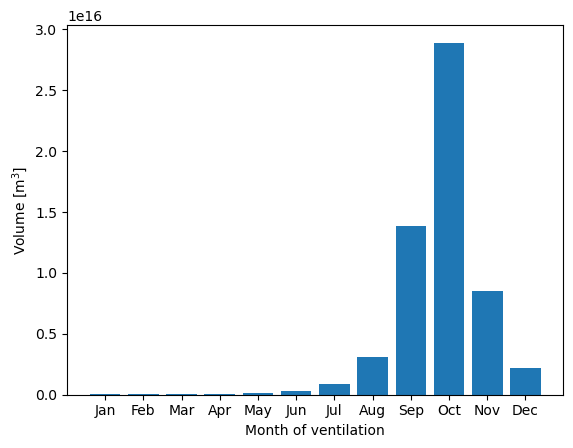

In [10]:
fig, ax = plt.subplots(dpi=100)
ax.bar(vol.month_o, vol.subvol_o)
ax.set_xticks(vol.month_o)
ax.set_xticklabels(cal_months)
ax.set_ylabel(r"Volume [m$^3$]")
ax.set_xlabel(r"Month of ventilation")

# Example of spatially-varying statistic calculation

In [11]:
# Isolate the necessary fields (month_o, subvol_o)
df = df_vent[['binnedx_o','binnedy_o','subvol_o']]

# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_o','binnedy_o'])

# Calculate total volume in each grid cell
vol_xy = df_group.sum("subvol_o").compute()

vol_xy.head(n=3)

subvol_o
binnedx_o binnedy_o              
2         109        8.910235e+10
          110        3.099374e+11
          113        7.701289e+10

vol_xy is currently a list of volumes indexed by combinations of binnedx_o and binnedy_o

To convert this into a gridded object we use the `DataFrame.to_xarray()` operation

In [12]:
da_vol_xy = vol_xy.to_xarray()["subvol_o"]

# Define coordinates x_c and y_c which are the Pythonic indices rather than the TRACMASS indices. This ensures agreement with the coordinates for ds_domain
da_vol_xy = da_vol_xy.assign_coords( {'x_c':da_vol_xy.binnedx_o - 1, 'y_c':da_vol_xy.binnedy_o - 1} ) 
da_vol_xy = da_vol_xy.swap_dims({'binnedx_o':'x_c', 'binnedy_o':'y_c'})

# Reorder axes to agree with ds_subdomain
da_vol_xy = da_vol_xy.transpose("y_c","x_c",...)


# Align the coordinates of the grid file with the subdomain in da_vol_xy
ds_domain, da_vol_xy = xr.align( ds_domain, da_vol_xy )

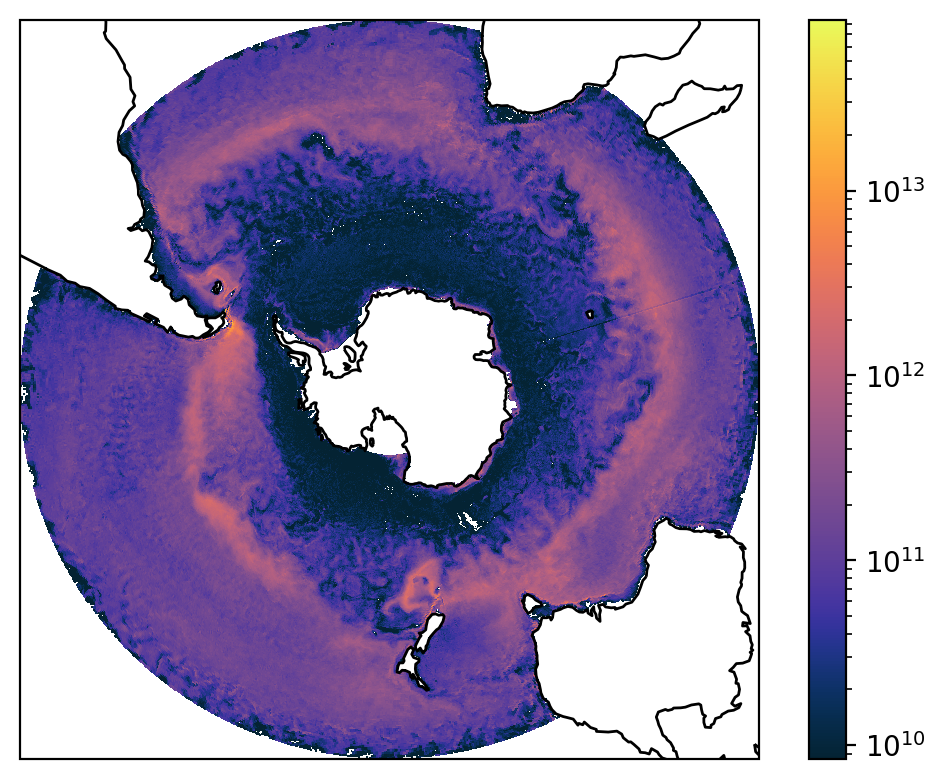

In [19]:
fig, ax = plt.subplots(1,1,dpi=200,subplot_kw={'projection':ccrs.SouthPolarStereo()})
lat = ds_domain.gphit
lon = ds_domain.glamt

vmax = da_vol_xy.max().compute()

lognorm = matplotlib.colors.LogNorm(vmax = vmax, vmin = vmax /1e4 )
cax = ax.pcolormesh( lon, lat, da_vol_xy, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, norm=lognorm )
ax.coastlines()
fig.colorbar(cax)

# Example of using neutral density

In [14]:
# Load the neutral density surfaces
ds_nd = xr.open_mfdataset(ndense_path, chunks='auto')

Define a function which maps from neutral density surface number to the exact neutral density

In [15]:
# 1D array of neutral density surface values
nd_coord = ds_nd.sigma_ver.values

def nd_bin_to_density( x ):
    # If x == -1 -> No density surface intersects the fluid column. Retain value of -1
    if x < 0:
        out = -1

    # Otherwise return the neutral density value
    else:
        out = nd_coord[ x - 1 ]

    return out

print("nd_bin_ini = 6 --> ", nd_bin_to_density( 6 ))
print("nd_bin_ini = 25 --> ", nd_bin_to_density( 25 ))
print("nd_bin_ini = -1 --> ", nd_bin_to_density( -1 ))

nd_bin_ini = 6 -->  1025.6791180985756
nd_bin_ini = 25 -->  1026.79379935536
nd_bin_ini = -1 -->  -1


Apply this function to all entries in `df_vent`

In [16]:
df_vent['ndense'] = df_vent['nd_bin_ini'].apply(nd_bin_to_density, meta=('sigma_ver',float))

# Group the data by their initial neutral density value

In [17]:
vol_nd = df_vent[['ndense','subvol_i', 'subvol_o']].groupby('ndense').sum().reset_index()

# If we like, we can remove the cases where no density surfaces don't intersect the fluid column
vol_nd = vol_nd[ vol_nd['ndense'] >= 0 ]

Text(0.5, 0, 'Initial neutral density [kg m$^{-3}$]')

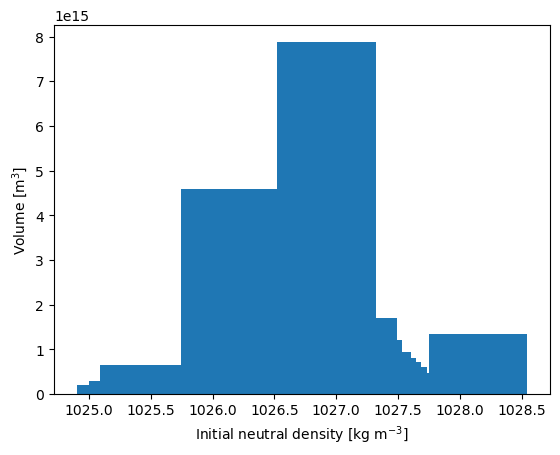

In [18]:
fig, ax = plt.subplots(dpi=100)
ax.bar(vol_nd['ndense'].compute(), vol_nd['subvol_o'].compute(),)
ax.set_ylabel(r"Volume [m$^3$]")
ax.set_xlabel(r"Initial neutral density [kg m$^{-3}$]")